# FINAL PROJECT: ISM 6562 - BIG DATA FOR BUSINESS

## **Setup Steps**

> ⚠️ **Note:** You must have a Java Development Kit (JDK) installed and the `JAVA_HOME` environment variable correctly configured.

- **For Windows**: The stable JDK version as of May 3, 2025, is **Java 11**.  
- **For macOS**: The stable version is **Java 17**, available from [Adoptium](https://adoptium.net/).

### 📦 Ensure All Required Packages Are Installed
Automatically installs missing Python packages using pip. This is useful for making your notebook portable and reproducible on other systems.

In [1]:
import importlib.util
import subprocess
import sys

# List of packages to ensure are installed
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "ucimlrepo",
    "pyspark",
    "scikit-learn",       # scikit-learn's import name is 'sklearn'
    "findspark"
]

for package in packages:
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")


numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
ucimlrepo is already installed.
pyspark is already installed.
Installing scikit-learn...
findspark is already installed.


### 📚 Import Libraries
Load all necessary Python and PySpark libraries for data manipulation, visualization, and machine learning pipeline construction.

In [2]:
# Importing libraries
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StandardScaler, PCA

sns.set_theme(palette="viridis")

### ⚙️ Initialize Spark and Confirm Environment
Finds and initializes the Spark environment using `findspark`, printing the Spark installation path to confirm.

In [3]:
findspark.init() 
# If you have a SPARK_HOME environment variable set, it might find it automatically
spark_path = findspark.find()
print(spark_path)

c:\Users\Owner\anaconda3\Lib\site-packages\pyspark


### 📥 Load UCI Communities and Crime Dataset
Fetches dataset #183 from the UCI ML repository using `ucimlrepo`, and combines the features and target into a single pandas DataFrame.

In [4]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 

# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

df = pd.concat([X, y], axis=1)

## 🧮 **Data Loading & Session Setup**

### 🔌 Initialize Spark Session
Starts a new Spark session which allows running distributed computations on the dataset.

In [5]:
spark = SparkSession.builder.appName("CommunitiesCrime").getOrCreate()

### 🔄 Prepare Spark SQL Table
Converts the pandas DataFrame to a Spark DataFrame and registers it as a temporary SQL table named `raw_crime`.

In [6]:
spark_df = spark.createDataFrame(df)
spark_df.show()

+-----+------+---------+--------------------+----+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+----------

In [7]:
spark_df.createOrReplaceTempView("raw_crime")

### 🧼 Clean Missing or Placeholder Values
Replaces any `'?'` string values with `NULL` using Spark SQL's `NULLIF` function, enabling safe type casting and filtering later.

In [8]:
columns = spark_df.columns

sql_expr = ",\n".join(
    [f"NULLIF({col}, '?') AS {col}" for col in columns]
)

query = f"SELECT {sql_expr} FROM raw_crime"
clean_df = spark.sql(query)
clean_df.createOrReplaceTempView("clean_crime")

## 🧹 **Data Cleaning & Casting**

### 🗃 Preserve State Info for Later Ranking
Creates a smaller DataFrame containing only `state` and `ViolentCrimesPerPop` to be joined back later for state-wise ranking analysis.

In [9]:
#Perserving "State" and "ViolentCrimes" references for use later in further data manipulation
state_df = clean_df.select("state", "ViolentCrimesPerPop")

### 🗑 Drop Irrelevant Identifier Columns
Removes columns like `state`, `county`, and `communityname` that are not useful for modeling. The goal is to retain only meaningful numeric features.

In [10]:
cols_to_drop = ["state", "county", "community", "communityname", "fold"]
selected_cols = [c for c in clean_df.columns if c not in cols_to_drop]
clean_df = clean_df.select(*selected_cols)
clean_df.createOrReplaceTempView("final_crime")

### 🔢 Convert Columns to Numeric Types
Casts all remaining columns to `DOUBLE` type for compatibility with machine learning operations in PySpark (e.g., VectorAssembler, PCA).

In [11]:
numeric_cast_expr = ",\n".join(
    [f"CAST({col} AS DOUBLE) AS {col}" for col in selected_cols]
)
spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime").createOrReplaceTempView("tidy_crime")

casted_df = spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime")
casted_df.createOrReplaceTempView("tidy_crime")

### 🧽 Final Tidy Dataset
Displays the cleaned and fully numeric dataset. This Spark DataFrame is now ready for vectorization and modeling.

In [12]:
# This is your clean, tidy, and numeric Spark DataFrame
tidy_df = spark.sql("SELECT * FROM tidy_crime")
tidy_df.show()

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## 🔧 **Feature Engineering Pipeline**

### ⚙️ Assemble & Normalize Features for Modeling
Use case: Combine multiple numeric features into a single vector column named `features` using `VectorAssembler`, while skipping over any invalid entries. Normalize the `features` column using `StandardScaler` so each feature has zero mean and unit variance, improving model performance.

Why it's useful: This is a prerequisite for feeding data into ML models like linear regression or random forest.

In [14]:
# Select features that potentially correlate with the target variable
feature_cols = ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp',
                'medIncome', 'pctUrban', 'PctPopUnderPov', 'PctLess9thGrade', 'PctUnemployed', 'PersPerFam',
                'PctKids2Par', 'PctIlleg', 'NumImmig', 'PctLargHouseFam', 'PersPerOccupHous', 'NumStreet', 'NumInShelters',
                'PolicOperBudg', 'PolicPerPop']
 
# Then assemble
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

# Then scale
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)

### 🔽 Apply PCA (Principal Component Analysis) for Feature Selection


In [16]:
# Set up PCA model
pca = PCA(k=20, inputCol='scaledFeatures', outputCol='pcaFeatures')

# Fit and transform the data
tidy_df_assembled = assembler.transform(tidy_df)
tidy_df_scaled = scaler.fit(tidy_df_assembled).transform(tidy_df_assembled)
tidy_df_pca = pca.fit(tidy_df_scaled)
 

Py4JJavaError: An error occurred while calling o194.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 2.0 failed 1 times, most recent failure: Lost task 1.0 in stage 2.0 (TID 3) (10.226.91.159 executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:513)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:202)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:170)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:777)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:513)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:202)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:170)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:777)
	... 34 more


In [ ]:
from pyspark.ml.linalg import DenseMatrix
 
# Get the PCs (loadings)
pc_matrix = tidy_df_pca.pc.toArray() 
 
# Replace this with the actual list of the original feature names
original_feature_names = feature_cols
loadings_df = pd.DataFrame(pc_matrix, index=original_feature_names)
 
print("Loadings Matrix:")
print(loadings_df)
 
# Get the explained variance
# Note: The explained variance is the eigenvalues of the covariance matrix of the data 
explained_variance = tidy_df_pca.explainedVariance.toArray()
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
 
print("\nExplained Variance:")
print(explained_variance_df)

In [ ]:
# Select top 8 features based on the average absolute loading
n_pc_to_consider = 3
top_n_features = 10
 
# Calculate the average absolute loading for each feature across the first n components
average_loadings = loadings_df.iloc[:, :n_pc_to_consider].abs().mean(axis=1)
selected_features = list(average_loadings.nlargest(top_n_features).index)
print(f"\nTop {top_n_features} features based on first {n_pc_to_consider} PCs: {selected_features}")

### Create the New Data Frame for Model Building Later

In [ ]:
columns_to_select = selected_features + [dependent_variable]
result_df = tidy_df.select(*columns_to_select)
result_df.show()

## 📊 **Visual Exploration**

### 📉 Generate Correlation Heatmap
Computes and visualizes the correlation matrix of features in a 20% sample of the dataset. This helps identify multicollinearity and feature relevance.

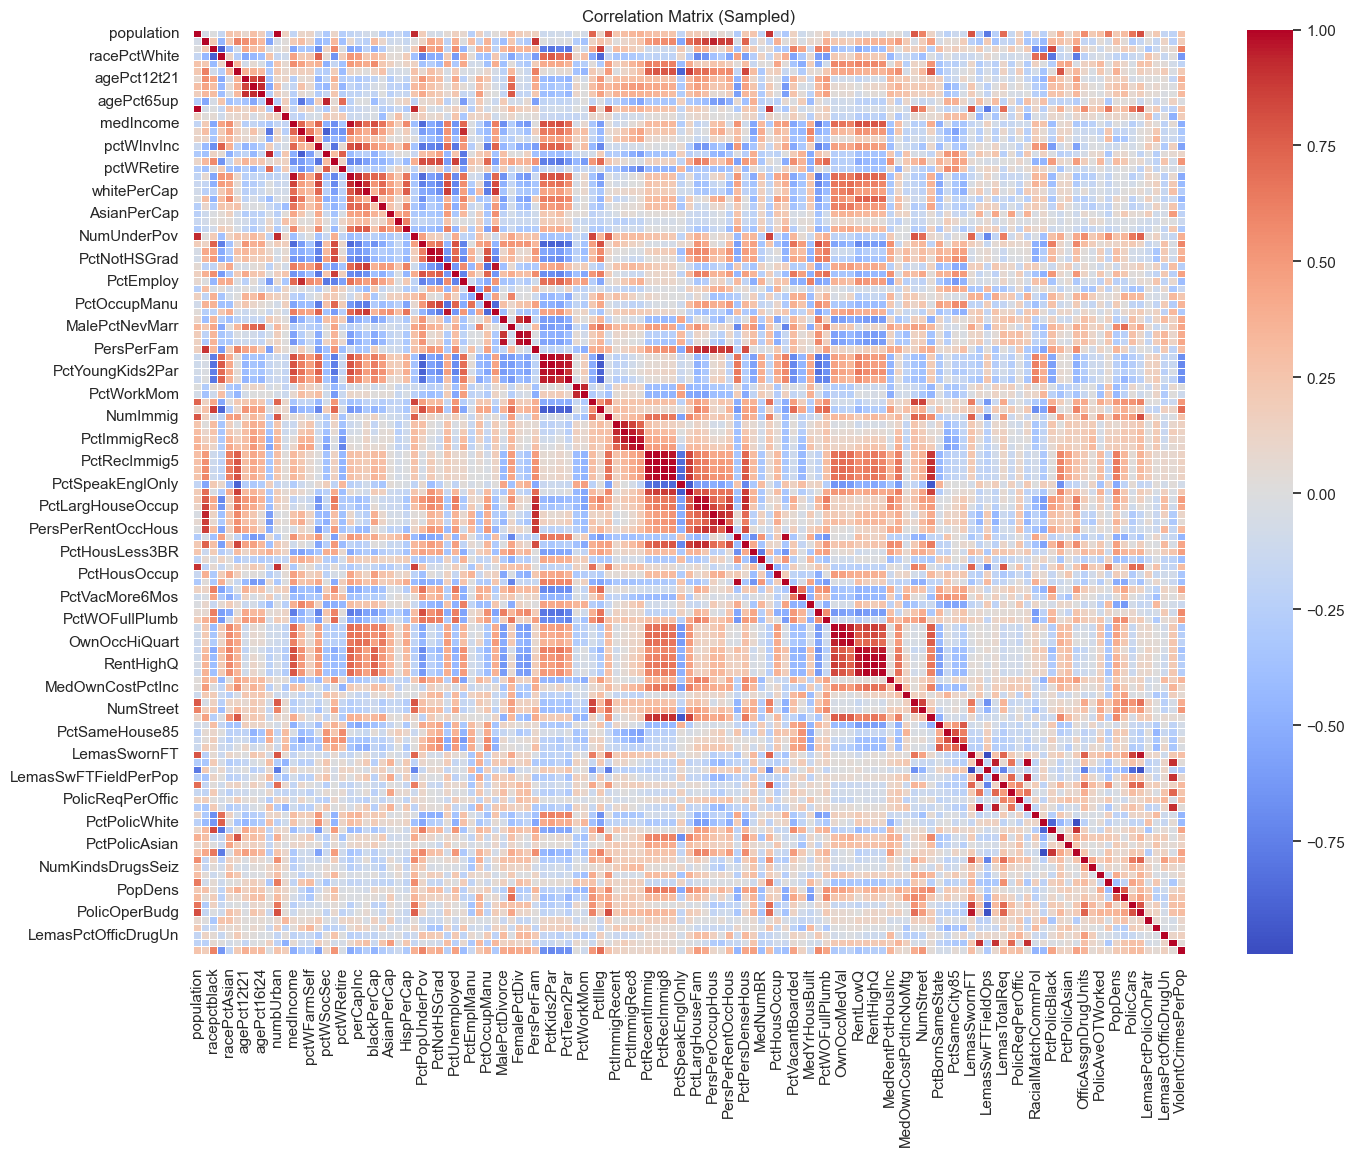

In [20]:
# Convert Spark DataFrame to Pandas
sample_pd_df = tidy_df.sample(False, 0.2, seed=42).toPandas()  # Sample 20% to avoid memory overload

# Drop any remaining nulls
sample_pd_df.dropna(inplace=True)

# ===========================
# 📊 Correlation Heatmap
# ===========================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
corr_matrix = sample_pd_df.corr(numeric_only=True)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Sampled)")
plt.show()


### 🧮 Visualize Crime Rate Distribution
Displays the frequency distribution of the target variable `ViolentCrimesPerPop` using a histogram with a KDE overlay.

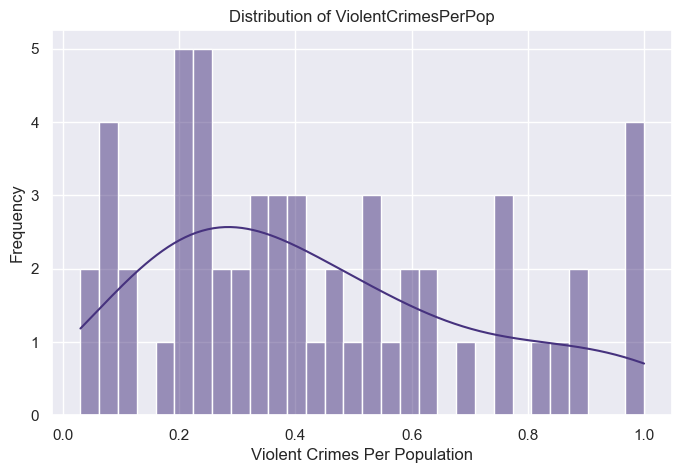

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(sample_pd_df['ViolentCrimesPerPop'], bins=30, kde=True)
plt.title("Distribution of ViolentCrimesPerPop")
plt.xlabel("Violent Crimes Per Population")
plt.ylabel("Frequency")
plt.show()


### 📦 Income Distribution by Crime Level
Visualizes how median income varies across binned crime levels (Low, Medium, High) using a boxplot.

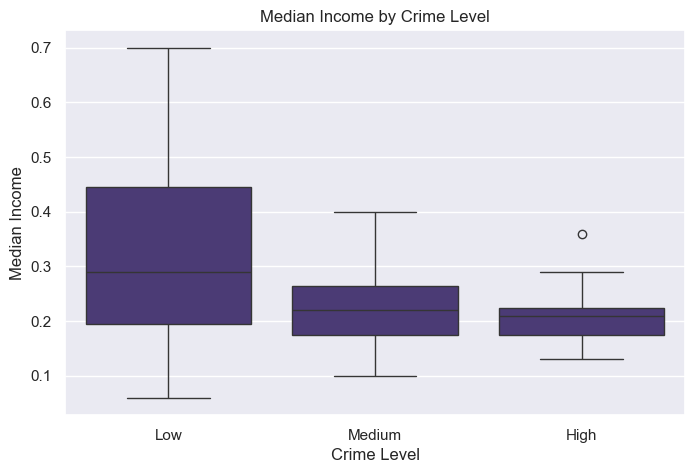

In [22]:
# Create 'crime_level' bin again for pandas
sample_pd_df["crime_level"] = pd.cut(
    sample_pd_df["ViolentCrimesPerPop"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

plt.figure(figsize=(8, 5))
sns.boxplot(x="crime_level", y="medIncome", data=sample_pd_df)
plt.title("Median Income by Crime Level")
plt.xlabel("Crime Level")
plt.ylabel("Median Income")
plt.show()


### 📈 Scatterplot: Poverty vs Crime
Shows the relationship between poverty rate and violent crime rate using a scatter plot to identify possible trends or clusters.

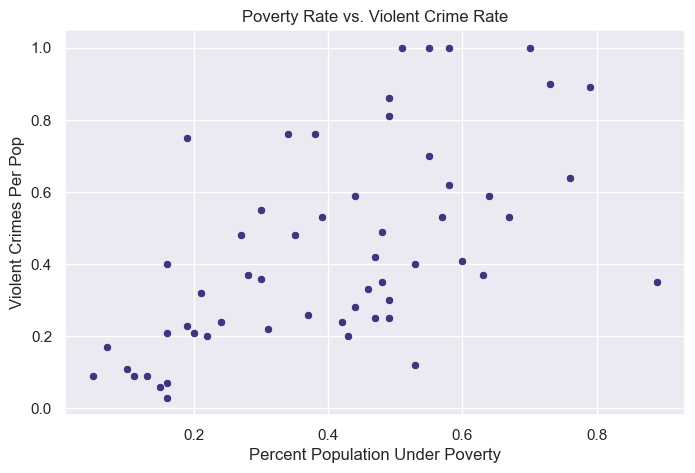

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="PctPopUnderPov", y="ViolentCrimesPerPop", data=sample_pd_df)
plt.title("Poverty Rate vs. Violent Crime Rate")
plt.xlabel("Percent Population Under Poverty")
plt.ylabel("Violent Crimes Per Pop")
plt.show()


## 📊 **SQL-Based Analysis**

### 🧮 Create SQL View for Result DataFrame
Registers the final transformed DataFrame as a temporary SQL view to enable SQL queries for further analysis.

In [24]:
# Create a SQL view from result_df
result_df.createOrReplaceTempView("final_result")

### 🧱 Bin Crime Levels in SQL
Adds a new column `crime_level` by categorizing the `ViolentCrimesPerPop` variable into High, Medium, or Low for easier group analysis.

In [25]:
# Create binned crime levels
spark.sql("""
    SELECT *,
        CASE 
            WHEN ViolentCrimesPerPop >= 0.7 THEN 'High'
            WHEN ViolentCrimesPerPop >= 0.4 THEN 'Medium'
            ELSE 'Low'
        END AS crime_level
    FROM final_result
""").createOrReplaceTempView("binned_result")

### 📊 Summary Stats by Crime Level
Aggregates key socioeconomic indicators (income, poverty, police budget) by crime level to find patterns across different crime intensities.

In [26]:
# Analyze poverty vs crime_level
spark.sql("""
    SELECT crime_level,
        COUNT(*) AS total_communities,
        ROUND(AVG(medIncome), 0) AS avg_median_income,
        ROUND(AVG(PctPopUnderPov), 2) AS avg_pct_under_poverty,
        ROUND(AVG(PolicOperBudg), 2) AS avg_police_budget
    FROM binned_result
    GROUP BY crime_level
    ORDER BY crime_level
""").show()

+-----------+-----------------+-----------------+---------------------+-----------------+
|crime_level|total_communities|avg_median_income|avg_pct_under_poverty|avg_police_budget|
+-----------+-----------------+-----------------+---------------------+-----------------+
|       High|               62|              0.0|                 0.55|             0.15|
|        Low|              160|              0.0|                 0.29|             0.03|
|     Medium|               97|              0.0|                 0.46|              0.1|
+-----------+-----------------+-----------------+---------------------+-----------------+



### 🔟 Top 10 Poorest, Most Violent Communities
Lists the top 10 communities with the highest poverty and violent crime rates to highlight potential areas of concern.

In [27]:
spark.sql("""
    SELECT *
    FROM tidy_crime
    WHERE PctPopUnderPov IS NOT NULL AND ViolentCrimesPerPop IS NOT NULL
    ORDER BY PctPopUnderPov DESC, ViolentCrimesPerPop DESC
    LIMIT 10
""").show(truncate=False)

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

### 🧭 Crime Rankings by State
Reattaches the preserved `state` column and ranks communities within each state by their violent crime rate using Spark SQL's window functions.

In [28]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row indices to join safely
with_state = tidy_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = state_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = with_state_info.drop("ViolentCrimesPerPop")

# Reattach 'state'
final_df = with_state.join(with_state_info, on="row_id").drop("row_id")
final_df.createOrReplaceTempView("final_with_state")


In [29]:
spark.sql("""
    SELECT *, 
        RANK() OVER (PARTITION BY state ORDER BY ViolentCrimesPerPop DESC) AS crime_rank_in_state
    FROM final_with_state
""").createOrReplaceTempView("crime_ranks_by_state")

spark.sql("""
    SELECT * FROM crime_ranks_by_state
    WHERE crime_rank_in_state = 1
""").show(truncate=False)

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## SparkML Analysis

### 🚀 Model Training and Evaluation

We implemented four regression models using SparkML to predict violent crime rates:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient-Boosted Trees Regressor

We evaluated model performance using Root Mean Squared Error (RMSE) on a held-out test set.

### 🛠 Data Split and Evaluator

We split the dataset into training (80%) and testing (20%) sets to evaluate model performance.  
We also defined a regression evaluator using RMSE (Root Mean Squared Error) as our main metric.

In [30]:
# Import SparkML regression models and evaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the dataset into training (80%) and testing (20%) sets
train_df, test_df = result_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the regression evaluator with RMSE metric
evaluator = RegressionEvaluator(
    labelCol="ViolentCrimesPerPop",    
    predictionCol="prediction",       
    metricName="rmse"                  
)

### 🚀 Train and Evaluate Models

We trained four models and evaluated their performance on the test set.  
For each model, we computed the RMSE and printed the results.

In [31]:
# Define the four regression models to evaluate
models = {
    "Linear Regression": LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Random Forest Regressor": RandomForestRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Gradient Boosted Trees": GBTRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop')
}

# Prepare a list to store model names and RMSE scores
results = []

# Loop over each model, train, predict, and evaluate
for name, model in models.items():
    fitted_model = model.fit(train_df)
    test_predictions = fitted_model.transform(test_df)
    test_rmse = evaluator.evaluate(test_predictions)
    
    train_predictions = fitted_model.transform(train_df)
    train_rmse = evaluator.evaluate(train_predictions)
    
    results.append((name, train_rmse, test_rmse))
    print(f"{name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


25/05/06 11:02:47 WARN Instrumentation: [883c471f] regParam is zero, which might cause numerical instability and overfitting.


Linear Regression - Train RMSE: 0.1549, Test RMSE: 0.1729
Decision Tree Regressor - Train RMSE: 0.1253, Test RMSE: 0.2474
Random Forest Regressor - Train RMSE: 0.1238, Test RMSE: 0.1862
Gradient Boosted Trees - Train RMSE: 0.0278, Test RMSE: 0.2516


### Summarize Model Performance

We summarized the RMSE scores in a sorted table to easily identify the best-performing model.

In [32]:
# Import pandas for creating a summary table
import pandas as pd

summary_df = pd.DataFrame(results, columns=['Model', 'Train_RMSE', 'Test_RMSE'])
print(summary_df)

                     Model  Train_RMSE  Test_RMSE
0        Linear Regression    0.154872   0.172890
1  Decision Tree Regressor    0.125289   0.247386
2  Random Forest Regressor    0.123845   0.186155
3   Gradient Boosted Trees    0.027761   0.251578


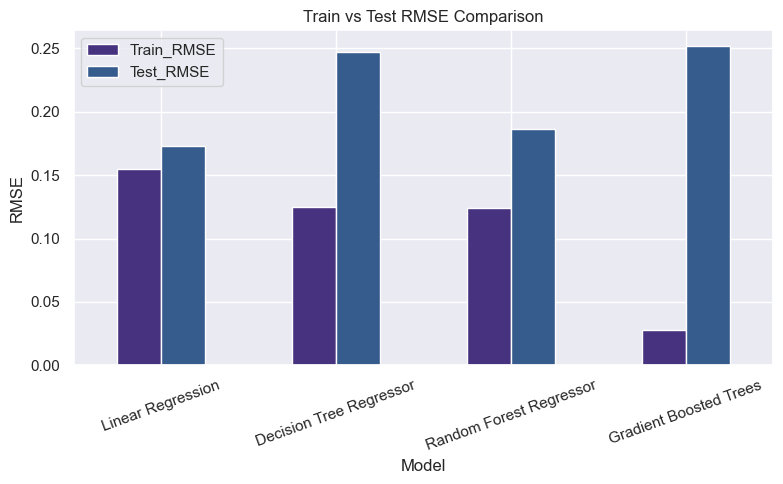

25/05/06 11:02:55 WARN Instrumentation: [d59657b3] regParam is zero, which might cause numerical instability and overfitting.


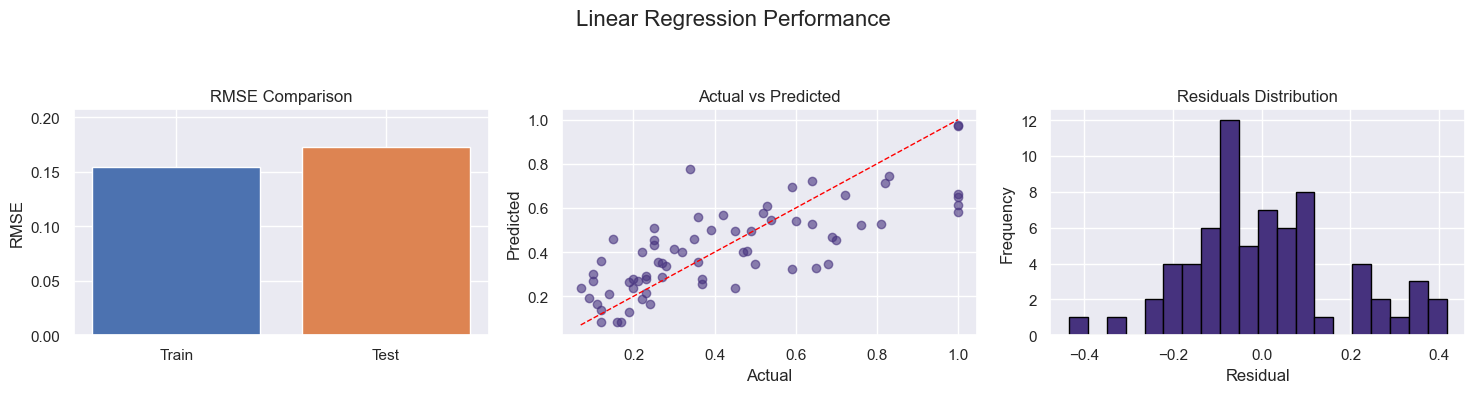

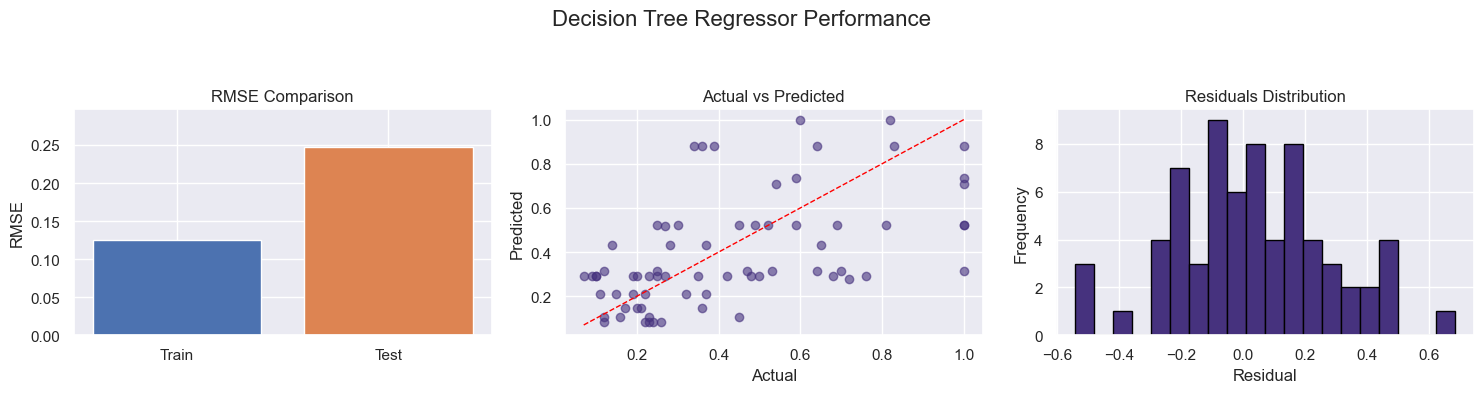

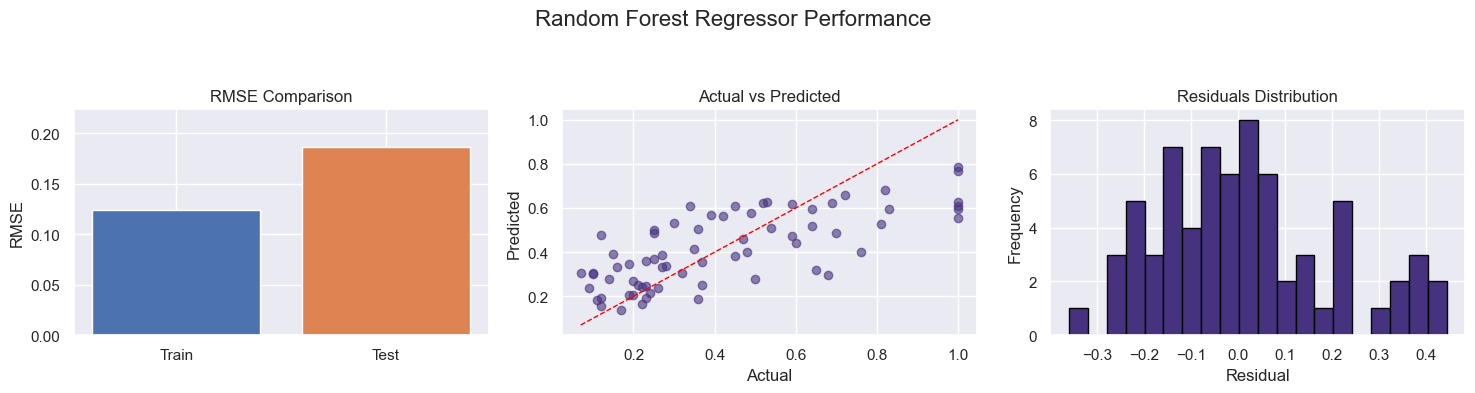

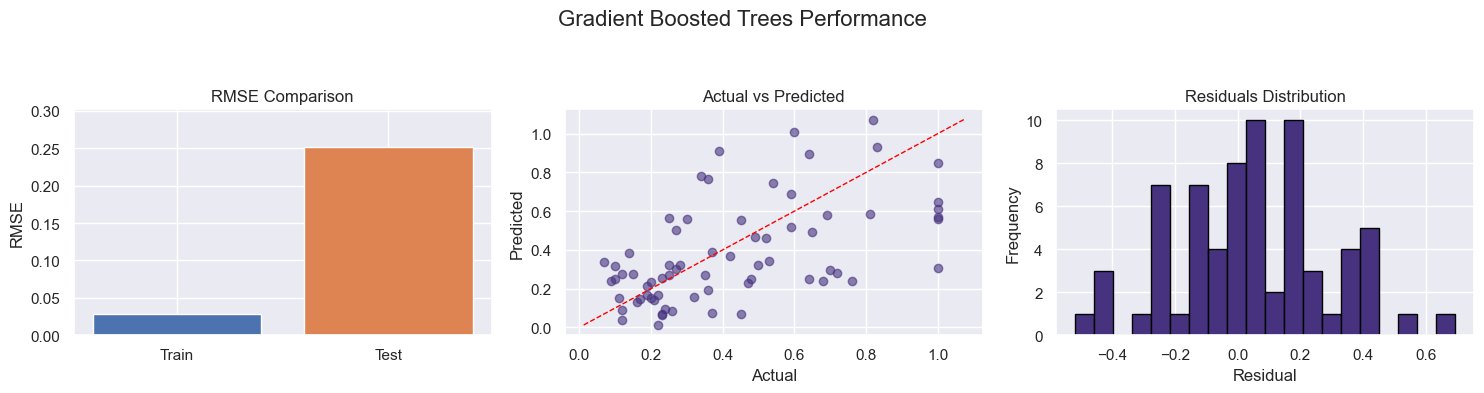

In [33]:
# Bar chart
df_reset = summary_df.reset_index() 
df_reset.plot(
    x='Model', 
    y=['Train_RMSE','Test_RMSE'],
    kind='bar',
    figsize=(8,5),
    rot=20
)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Comparison")
plt.tight_layout()
plt.show()


for name, train_rmse, test_rmse in results:
    est = models[name]
    fitted = est.fit(train_df)
    test_pred = fitted.transform(test_df)
    pdf = test_pred.select("ViolentCrimesPerPop","prediction").toPandas()
    pdf["residual"] = pdf["ViolentCrimesPerPop"] - pdf["prediction"]

    fig, axes = plt.subplots(1,3,figsize=(15,4))
    fig.suptitle(f"{name} Performance", fontsize=16)

    # RMSE comparison
    axes[0].bar(["Train","Test"], [train_rmse, test_rmse],
                color=['#4C72B0','#DD8452'])
    axes[0].set_ylim(0, max(train_rmse,test_rmse)*1.2)
    axes[0].set_title("RMSE Comparison")
    axes[0].set_ylabel("RMSE")

    # Actual vs Predicted
    axes[1].scatter(pdf["ViolentCrimesPerPop"], pdf["prediction"], alpha=0.6)
    mn, mx = pdf[["ViolentCrimesPerPop","prediction"]].values.min(), pdf[["ViolentCrimesPerPop","prediction"]].values.max()
    axes[1].plot([mn,mx],[mn,mx],"r--",linewidth=1)
    axes[1].set_title("Actual vs Predicted")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")

    # Residuals
    axes[2].hist(pdf["residual"], bins=20, edgecolor="k")
    axes[2].set_title("Residuals Distribution")
    axes[2].set_xlabel("Residual")
    axes[2].set_ylabel("Frequency")

    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()


### ⚙️ Advanced SparkML Features

We implemented:
- Cross-validation + hyperparameter tuning for Linear Regression using `CrossValidator` and `ParamGridBuilder`.
- Feature importance extraction for Random Forest to interpret which PCA components influence predictions the most.

These advanced techniques improve model robustness and interpretability.

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Linear Regression model
lr = LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop')

# Build parameter grid to test different regularization values
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up 3-fold cross-validator
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

# Run cross-validation on training set
cv_model = cv.fit(train_df)

# Evaluate the best model on the test set
cv_predictions = cv_model.transform(test_df)
cv_rmse = evaluator.evaluate(cv_predictions)

print(f"\nBest Linear Regression (CV) RMSE: {cv_rmse:.4f}")



Best Linear Regression (CV) RMSE: 0.1739


### 🔎 Feature Importance and Coefficients

We extracted:
- Decision Tree, Random Forest, and Gradient Boosted Trees feature importances on PCA components.
- Linear Regression coefficients on PCA components.

Since we used PCA, importances and coefficients apply to principal components, not the original features.

In [35]:
# Decision Tree Regressor
dt_model = DecisionTreeRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
dt_importances = dt_model.featureImportances.toArray()
dt_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(dt_importances))],
    'Importance': dt_importances
}).sort_values('Importance', ascending=False)
print("\nDecision Tree Feature Importances:")
print(dt_df)

# Random Forest Regressor
rf_model = RandomForestRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
rf_importances = rf_model.featureImportances.toArray()
rf_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(rf_importances))],
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances:")
print(rf_df)

# Gradient Boosted Trees Regressor
gbt_model = GBTRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
gbt_importances = gbt_model.featureImportances.toArray()
gbt_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(gbt_importances))],
    'Importance': gbt_importances
}).sort_values('Importance', ascending=False)
print("\nGradient Boosted Trees Feature Importances:")
print(gbt_df)

# Linear Regression Coefficients (note: only meaningful without PCA)
lr_model = LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
lr_coefficients = lr_model.coefficients.toArray()
lr_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(lr_coefficients))],
    'Coefficient': lr_coefficients
}).sort_values('Coefficient', key=abs, ascending=False)
print("\nLinear Regression Coefficients (on PCA components):")
print(lr_df)



Decision Tree Feature Importances:
   PCA Component  Importance
0            PC1    0.657620
7            PC8    0.100256
4            PC5    0.063508
10          PC11    0.047029
3            PC4    0.032830
12          PC13    0.025616
8            PC9    0.019512
9           PC10    0.017764
6            PC7    0.012931
14          PC15    0.012772
17          PC18    0.006148
1            PC2    0.002103
18          PC19    0.001912
5            PC6    0.000000
2            PC3    0.000000
11          PC12    0.000000
13          PC14    0.000000
15          PC16    0.000000
16          PC17    0.000000
19          PC20    0.000000

Random Forest Feature Importances:
   PCA Component  Importance
0            PC1    0.486066
7            PC8    0.075329
4            PC5    0.053667
2            PC3    0.053047
16          PC17    0.033072
17          PC18    0.031537
3            PC4    0.030131
1            PC2    0.028436
6            PC7    0.027497
19          PC20    0.025270


25/05/06 11:03:12 WARN Instrumentation: [81684633] regParam is zero, which might cause numerical instability and overfitting.


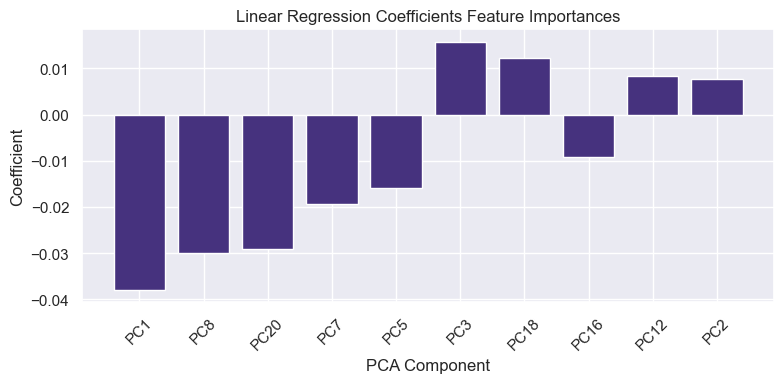

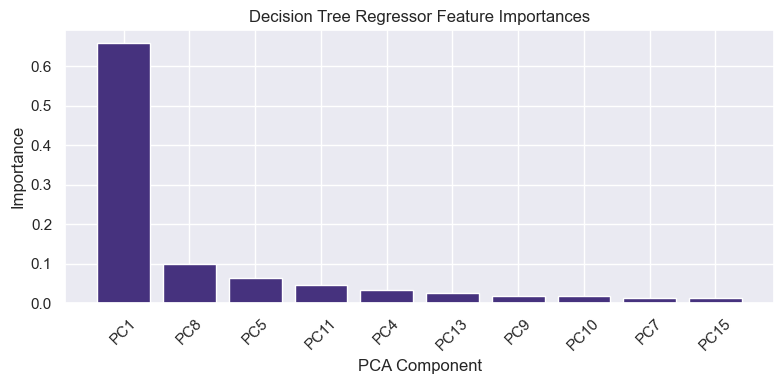

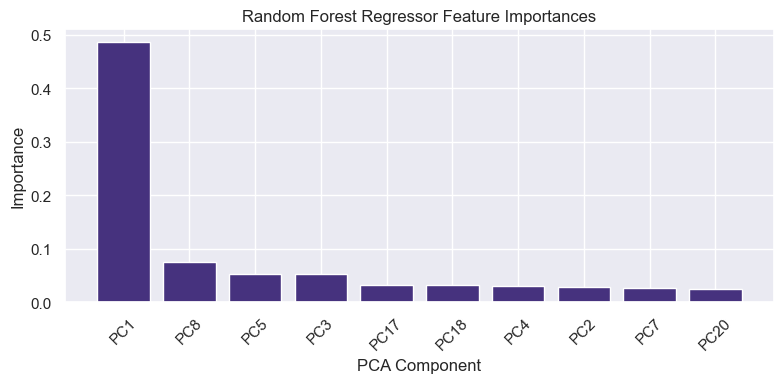

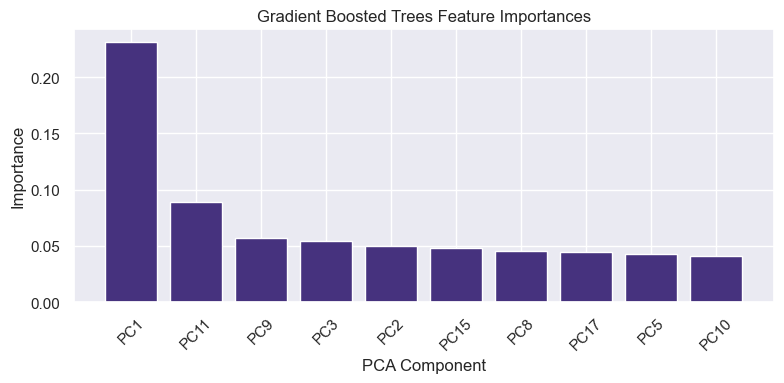

In [36]:
# Plot feature importances 
models_info = [
    (lr_df, 'Coefficient', 'Linear Regression Coefficients'),
    (dt_df, 'Importance', 'Decision Tree Regressor'),
    (rf_df, 'Importance', 'Random Forest Regressor'),
    (gbt_df, 'Importance', 'Gradient Boosted Trees')
]

for df, value_col, title in models_info:
    # Take top 10 components
    top_df = df.head(10)
    
    plt.figure(figsize=(8, 4))
    plt.bar(top_df['PCA Component'], top_df[value_col])
    plt.title(f'{title} Feature Importances')
    plt.xlabel('PCA Component')
    plt.ylabel(value_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()